# Code for testing Conditional Distributions for VAE Work 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch

from janelia_core.ml.torch_distributions import CondBernoulliDistribution
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondSpikeSlabDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.ml.extra_torch_modules import LogGaussianBumpFcn

## Here we generate properites for neurons we simulate conditioning on

In [3]:
# Properties of neurons we condition on 
n_neurons = 2000
neuron_props = torch.zeros(n_neurons, 2).uniform_()

## Define a helper function for visualizing distributions

In [4]:
def visualize_mean(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
           y_range[0]:y_range[1]:n_points_per_side * 1j]

    grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
    grid_vec = torch.from_numpy(grid_vec.astype('float32'))

    mn_vec = d(grid_vec).detach().numpy()
    mn_image = np.reshape(mn_vec, [n_points_per_side, n_points_per_side])
    
    plt.imshow(mn_image, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')
    plt.colorbar()

## We pick one of the cells below to setup testing with a particular kind of distribution

In [ ]:
## For Bernoulli distributions

p_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=10.0, ctr_std_init=.5,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.05)
p = CondBernoulliDistribution(p_log_prob_fcn)

q_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=10.0, ctr_std_init=.1,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.05)
q = CondBernoulliDistribution(q_log_prob_fcn)

r_params = list() # Parameters which the gradient can be calculated for with the reparm trick
s_params = list(q.parameters()) # Params we use the score function to calcualte gradients for


In [ ]:
## For Gaussian distributions

p_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,25), torch.nn.ReLU(), torch.nn.Linear(25, 25), torch.nn.ReLU(), 
                               torch.nn.Linear(25,1))

p_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.1]), upper_bound=np.asarray([10]), 
                               init_value=np.asarray(2.0))

p = CondGaussianDistribution(mn_f=p_mn_fcn, std_f=p_std_fcn)

q_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,25), torch.nn.ReLU(), torch.nn.Linear(25, 25), torch.nn.ReLU(), 
                               torch.nn.Linear(25,1))

q_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.1]), upper_bound=np.asarray([100]), 
                               init_value=np.asarray(1.0))

q = CondGaussianDistribution(mn_f=q_mn_fcn, std_f=q_std_fcn)

r_params = list(q.parameters())
s_params = list()

In [33]:
## Spike and Slab distribution 

p_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=10.0, ctr_std_init=.5,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.05)
p_spike_d = CondBernoulliDistribution(p_spike_log_prob_fcn)

#p_slab_mn_fcn = ConstantRealFcn(np.asarray([2]))
p_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,5), torch.nn.ReLU(), torch.nn.Linear(5, 5), torch.nn.ReLU(), 
                             torch.nn.Linear(5,1))


p_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.1]), upper_bound=np.asarray([10]), 
                               init_value=np.asarray(.25))

p_slab_d = CondGaussianDistribution(mn_f=p_slab_mn_fcn, std_f=p_slab_std_fcn)


p = CondSpikeSlabDistribution(d=1, spike_d=p_spike_d, slab_d=p_slab_d)

q_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=3.0, ctr_std_init=.2,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.05)
q_spike_d = CondBernoulliDistribution(q_spike_log_prob_fcn)

#q_slab_mn_fcn = ConstantRealFcn(np.asarray([2]))
q_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,5), torch.nn.ReLU(), torch.nn.Linear(5, 5), torch.nn.ReLU(), 
                             torch.nn.Linear(5,1))

q_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.1]), upper_bound=np.asarray([10]), 
                               init_value=np.asarray(.25))

q_slab_d = CondGaussianDistribution(mn_f=q_slab_mn_fcn, std_f=q_slab_std_fcn)


q = CondSpikeSlabDistribution(d=1, spike_d=q_spike_d, slab_d=q_slab_d)

r_params = list(q_slab_d.parameters()) # Parameters which the gradient can be calculated for with the reparm trick
s_params = list(q_spike_d.parameters()) # Params we use the score function to calcualte gradients for


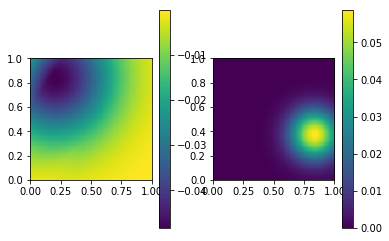

In [34]:
plt.figure()
plt.subplot(1,2,1)
visualize_mean(p)
plt.subplot(1,2,2)
visualize_mean(q)

## Minimize the KL divergence between q and p

it: 0, o_r: 1357.40673828125, o_s: -178.72305297851562
it: 1000, o_r: 2.970637321472168, o_s: 16.467378616333008
it: 2000, o_r: -0.27435097098350525, o_s: 3.053614854812622
it: 3000, o_r: 0.6633039116859436, o_s: -0.9085885882377625
it: 4000, o_r: 0.6402618288993835, o_s: -2.798755168914795
it: 5000, o_r: 0.05204423516988754, o_s: -3.52093768119812
it: 6000, o_r: 0.30349910259246826, o_s: -4.07133674621582
it: 7000, o_r: 0.027206487953662872, o_s: 2.4724233150482178
it: 8000, o_r: 0.13989968597888947, o_s: 4.163706302642822
it: 9000, o_r: 0.08764320611953735, o_s: -1.4672926664352417


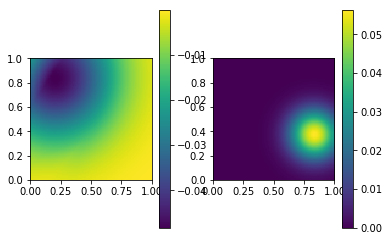

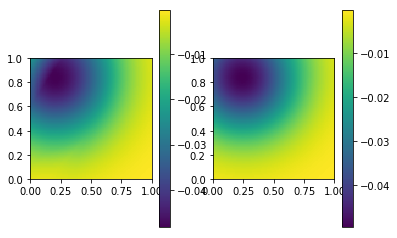

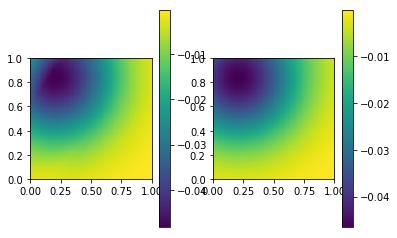

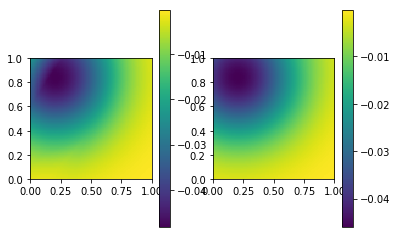

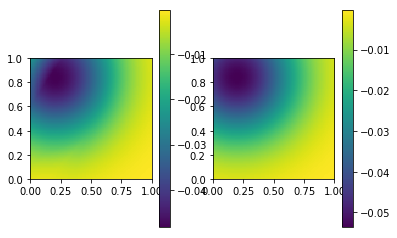

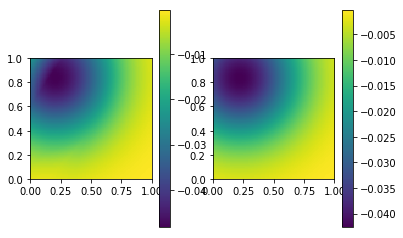

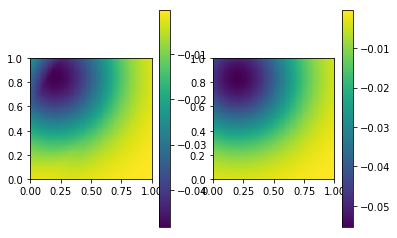

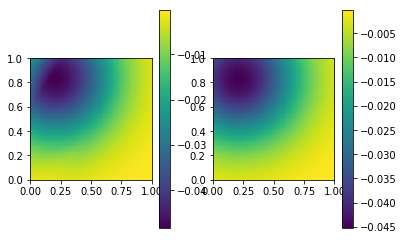

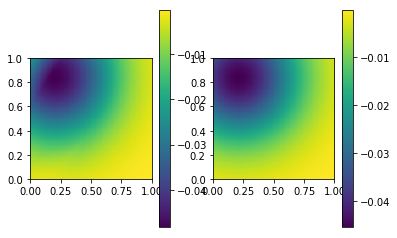

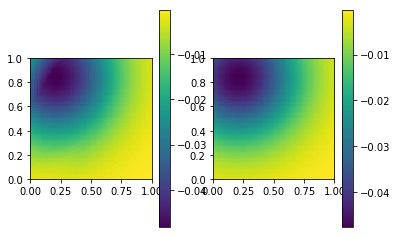

In [35]:
n_its = 10000
update_int = 1000

if len(r_params) > 0:
    r_optim = torch.optim.Adam(r_params)
    run_r_opt = True
else:
    run_r_opt = False
    
if len(s_params) > 0:
    s_optim = torch.optim.Adam(s_params)
    run_s_opt = True
else:
    run_s_opt = False
    
for i in range(n_its):
    
    # Don't need to calculate gradients for s_params yet
    for s_p in s_params:
        s_p.requires_grad = False
    
    # Sample q
    smp_i = q.sample(neuron_props)
    
    # Compute the learning signal 
    q_ll = q.log_prob(neuron_props, smp_i)
    p_ll = p.log_prob(neuron_props, smp_i)
    kl = q_ll - p_ll
    
    # Calculate gradients for anthing we can use the reparameterization trick on
    if run_r_opt:
        r_optim.zero_grad()
        o_r = torch.sum(kl)
        o_r.backward(retain_graph=run_s_opt)
    else:
        o_r = torch.zeros(1)
    
    # Now set things up so we will calculate gradients of s_params next
    for s_p in s_params:
        s_p.requires_grad = True
            
    # Calculate gradients for anything we can't use the reparameterization trick on
    if run_s_opt:
        for r_p in r_params:
            r_p.requires_grad = False
    
        # Detach the learning signal since we don't want to run gradients through it
        with torch.no_grad():
            ls = kl
            
        # Compute the objective for the score function and take a step
        s_optim.zero_grad()
        o_s = torch.sum(ls*q.log_prob(neuron_props, smp_i))
        o_s.backward()
        
        for r_p in r_params:
            r_p.requires_grad = True
    else:
        o_s = torch.zeros(1)
        
    # Take steps for both r and s parameters now 
    if run_r_opt:
        r_optim.step()
    if run_s_opt:
        s_optim.step()
 
    # Provide some feedback
    o_r_record = np.float(o_r.detach().numpy())
    o_s_record = np.float(o_s.detach().numpy())
    if i % update_int == 0:
        print('it: ' + str(i) + ', o_r: ' + str(o_r_record) + ', o_s: ' + str(o_s_record))

        plt.figure()
        plt.subplot(1,2,1)
        visualize_mean(p)
        plt.subplot(1,2,2)
        visualize_mean(q)
        